In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
%matplotlib inline


Transfer Learning for Computer Vision Tutorial
==============================================

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
image_transforms  = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=45),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

dataset = 'microsphere2'
train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')

batch_size = 16
num_classes = 173

data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid'])

}


train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

train_data = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=batch_size, shuffle=True)

print(train_data_size, valid_data_size)

1038 346


迁移学习
---------


这里使用ResNet-50的预训练模型。


In [5]:
resnet50 = models.resnet50(pretrained=True)

for param in resnet50.parameters():
    param.requires_grad = True

fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256,  173),
    nn.LogSoftmax(dim = 1)


)
resnet50 = resnet50.to('cuda:0')
loss_func = nn.NLLLoss()
optimizer = optim.AdamW(resnet50.parameters(),lr=1e-3)

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [6]:
def train_and_valid(model, loss_function, optimizer, epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    history = []
    best_acc = 0.0
    best_epoch = 0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        model.train()

        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_data):
            inputs = inputs.to(device)
            labels = labels.to(device)

            #因为这里梯度是累加的，所以每次记得清零
            optimizer.zero_grad()

            outputs = model(inputs)

            loss = loss_function(outputs, labels)

            loss.backward()

            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            train_acc += acc.item() * inputs.size(0)

        with torch.no_grad():
            model.eval()

            for j, (inputs, labels) in enumerate(valid_data):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)

                loss = loss_function(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                valid_acc += acc.item() * inputs.size(0)

        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1

        epoch_end = time.time()

        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
            epoch+1, avg_valid_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start
        ))
        print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
        dataset1 = 'E:\gmd_data\microsphere2_dataAugmented'
        torch.save(model, dataset1+'/models/'+'model_'+str(epoch+1)+'.pt')
#         torch.save(model, 'models/'+dataset+'_model_'+str(epoch+1)+'.pt')
        if epoch + 1 - 100 >  best_epoch:
            break
    return model, history


In [7]:
num_epochs = 3000
trained_model, history = train_and_valid(resnet50, loss_func, optimizer, num_epochs)
torch.save(history, 'models/'+dataset+'_history.pt')



Epoch: 1/3000
Epoch: 001, Training: Loss: 5.1540, Accuracy: 0.0963%, 
		Validation: Loss: 5.1540, Accuracy: 0.5780%, Time: 107.1861s
Best Accuracy for validation : 0.0058 at epoch 001
Epoch: 2/3000
Epoch: 002, Training: Loss: 5.1539, Accuracy: 0.3854%, 
		Validation: Loss: 5.1539, Accuracy: 0.5780%, Time: 40.0172s
Best Accuracy for validation : 0.0058 at epoch 002
Epoch: 3/3000
Epoch: 003, Training: Loss: 5.1525, Accuracy: 0.3854%, 
		Validation: Loss: 5.1525, Accuracy: 0.8671%, Time: 39.0196s
Best Accuracy for validation : 0.0087 at epoch 003
Epoch: 4/3000
Epoch: 004, Training: Loss: 5.1539, Accuracy: 0.6744%, 
		Validation: Loss: 5.1539, Accuracy: 0.5780%, Time: 37.3196s
Best Accuracy for validation : 0.0087 at epoch 003
Epoch: 5/3000
Epoch: 005, Training: Loss: 5.1539, Accuracy: 0.2890%, 
		Validation: Loss: 5.1539, Accuracy: 0.5780%, Time: 38.7533s
Best Accuracy for validation : 0.0087 at epoch 003
Epoch: 6/3000
Epoch: 006, Training: Loss: 5.1538, Accuracy: 0.0963%, 
		Validation: 

Epoch: 46/3000
Epoch: 046, Training: Loss: 5.1534, Accuracy: 0.1927%, 
		Validation: Loss: 5.1534, Accuracy: 0.5780%, Time: 38.9259s
Best Accuracy for validation : 0.0087 at epoch 003
Epoch: 47/3000
Epoch: 047, Training: Loss: 5.1534, Accuracy: 0.4817%, 
		Validation: Loss: 5.1534, Accuracy: 0.5780%, Time: 38.4105s
Best Accuracy for validation : 0.0087 at epoch 003
Epoch: 48/3000
Epoch: 048, Training: Loss: 5.1534, Accuracy: 0.3854%, 
		Validation: Loss: 5.1534, Accuracy: 0.5780%, Time: 38.5105s
Best Accuracy for validation : 0.0087 at epoch 003
Epoch: 49/3000
Epoch: 049, Training: Loss: 5.1534, Accuracy: 0.2890%, 
		Validation: Loss: 5.1534, Accuracy: 0.5780%, Time: 38.6558s
Best Accuracy for validation : 0.0087 at epoch 003
Epoch: 50/3000
Epoch: 050, Training: Loss: 5.1534, Accuracy: 0.0963%, 
		Validation: Loss: 5.1534, Accuracy: 0.5780%, Time: 38.5091s
Best Accuracy for validation : 0.0087 at epoch 003
Epoch: 51/3000
Epoch: 051, Training: Loss: 5.1534, Accuracy: 0.2890%, 
		Validat

Epoch: 091, Training: Loss: 5.1533, Accuracy: 0.5780%, 
		Validation: Loss: 5.1533, Accuracy: 0.5780%, Time: 38.9120s
Best Accuracy for validation : 0.0087 at epoch 003
Epoch: 92/3000
Epoch: 092, Training: Loss: 5.1533, Accuracy: 0.1927%, 
		Validation: Loss: 5.1533, Accuracy: 0.5780%, Time: 38.4909s
Best Accuracy for validation : 0.0087 at epoch 003
Epoch: 93/3000
Epoch: 093, Training: Loss: 5.1533, Accuracy: 0.0963%, 
		Validation: Loss: 5.1533, Accuracy: 0.5780%, Time: 38.4644s
Best Accuracy for validation : 0.0087 at epoch 003
Epoch: 94/3000
Epoch: 094, Training: Loss: 5.1533, Accuracy: 0.1927%, 
		Validation: Loss: 5.1533, Accuracy: 0.5780%, Time: 38.5537s
Best Accuracy for validation : 0.0087 at epoch 003
Epoch: 95/3000
Epoch: 095, Training: Loss: 5.1533, Accuracy: 0.1927%, 
		Validation: Loss: 5.1533, Accuracy: 0.5780%, Time: 38.2902s
Best Accuracy for validation : 0.0087 at epoch 003
Epoch: 96/3000
Epoch: 096, Training: Loss: 5.1533, Accuracy: 0.1927%, 
		Validation: Loss: 5.15

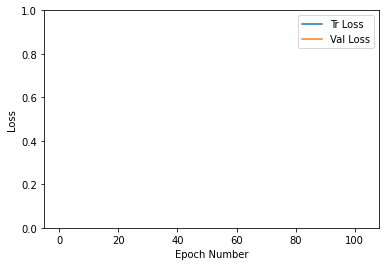

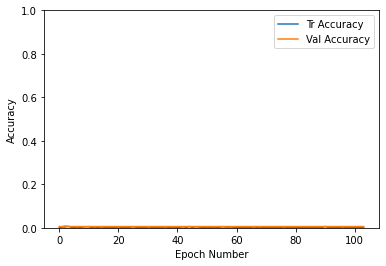

In [8]:
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

plt.plot(history[:, 2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()